### Домашнее задание

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv('./../../2Урок/lection2_materials/articles.csv')
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("./../../2Урок/lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


##### 1. Получаем векторные представления новостей

In [4]:
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2  # pip install pymorphy2

In [5]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)
morph = pymorphy2.MorphAnalyzer()

In [6]:
with open('./../../2Урок/lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n|\\nn|\\xnn|nn", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
#     text = re.sub(r'n', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Progs\Anaconda\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 27.5 s


In [9]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min


In [10]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [11]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 33 s


In [12]:
from gensim.test.utils import datapath 
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [14]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год фонд млн тыс доход это компания
topic_1: теория таиланд лодка палатка посадочный школьный развиться
topic_2: год млрд рубль который это рост россия
topic_3: дело суд сотрудник убийство мужчина который полиция
topic_4: год это который рынок наука земля время
topic_5: закон экипаж топливо законопроект снизиться медведев госдума
topic_6: год станция проект университет писать стать который
topic_7: это который год мочь также новый страна
topic_8: суд иск компания судья подать арбитражный решение
topic_9: газ день товар фестиваль пройти москва сайт
topic_10: президент это ракета страна который глава государство
topic_11: банк год турция компания турецкий памятник пресссекретарить
topic_12: медицина направлять полоса найтись кубинский реконструировать приступать
topic_13: украина россия российский украинский это сторона который
topic_14: проверка южный км маршрут предмет волна корея
topic_15: исследование военный обнаружить армия пациент взрыв выяснить
topic_16: женщина высота я

In [15]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [16]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.182211,0.0,0.000000,0.0,0.01943,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,4896,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.05672,...,0.688376,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,4897,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.049749,0.0,0.103164,0.718314,0.0,0.0
3,4898,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.458091,0.00000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.437343,0.0,0.0
4,4899,0.0,0.0,0.209874,0.0,0.229491,0.0,0.00000,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.385775,0.000000,0.0,0.0


#### Следующий шаг - векторные представления пользователей

In [17]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [18]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [19]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, axis=0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [20]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.031387,0.0,0.000000,0.068583,0.095815,0.006939,0.079724,0.229526,0.014789,...,0.022660,0.002077,0.000000,0.043609,0.008682,0.007809,0.018804,0.031854,0.024468,0.018511
1,u108690,0.051479,0.0,0.052301,0.061394,0.024492,0.012060,0.011922,0.194732,0.000000,...,0.006963,0.001864,0.001692,0.064702,0.002549,0.041996,0.014698,0.115322,0.018732,0.000000
2,u108339,0.016721,0.0,0.103767,0.113260,0.071639,0.014514,0.034861,0.083538,0.000000,...,0.047310,0.003815,0.000000,0.094025,0.000000,0.014401,0.019089,0.039923,0.074214,0.003508


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [21]:
target = pd.read_csv("./../../2Урок/lection2_materials/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [22]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.031387,0.0,0.000000,0.068583,0.095815,0.006939,0.079724,0.229526,0.014789,...,0.002077,0.000000,0.043609,0.008682,0.007809,0.018804,0.031854,0.024468,0.018511,0
1,u108690,0.051479,0.0,0.052301,0.061394,0.024492,0.012060,0.011922,0.194732,0.000000,...,0.001864,0.001692,0.064702,0.002549,0.041996,0.014698,0.115322,0.018732,0.000000,1
2,u108339,0.016721,0.0,0.103767,0.113260,0.071639,0.014514,0.034861,0.083538,0.000000,...,0.003815,0.000000,0.094025,0.000000,0.014401,0.019089,0.039923,0.074214,0.003508,1


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [24]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [25]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12730874, 0.04331949, 0.37972919, 0.20287507, 0.01263941,
       0.07228144, 0.24151916, 0.0551224 , 0.02837105, 0.13102961])

In [27]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

In [28]:
results=[]

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.232262, F-Score=0.675, Precision=0.575, Recall=0.816


In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1607  148]
 [  46  199]]


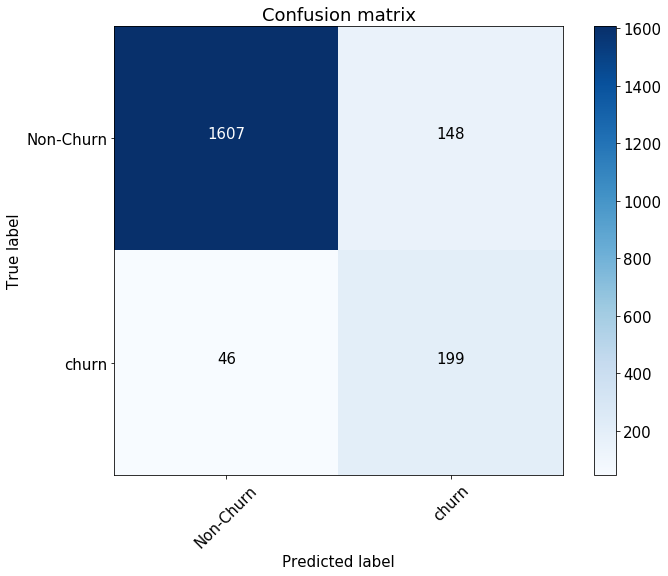

In [31]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [32]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9438967381824526

In [33]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

### Задача 2
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)


In [34]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [35]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.000000,0.047064,0.032803,0.0,0.049010,0.231583,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,u108690,0.009558,0.0,0.058497,0.040478,0.014975,0.0,0.000000,0.164719,0.0,...,0.000000,0.0,0.0,0.052149,0.0,0.019227,0.007849,0.062428,0.005063,0.0
2,u108339,0.000000,0.0,0.082656,0.134198,0.068508,0.0,0.023882,0.107984,0.0,...,0.054012,0.0,0.0,0.094597,0.0,0.000000,0.005593,0.037734,0.065919,0.0


In [36]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.000000,0.047064,0.032803,0.0,0.049010,0.231583,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0
1,u108690,0.009558,0.0,0.058497,0.040478,0.014975,0.0,0.000000,0.164719,0.0,...,0.0,0.0,0.052149,0.0,0.019227,0.007849,0.062428,0.005063,0.0,1
2,u108339,0.000000,0.0,0.082656,0.134198,0.068508,0.0,0.023882,0.107984,0.0,...,0.0,0.0,0.094597,0.0,0.000000,0.005593,0.037734,0.065919,0.0,1


In [37]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [38]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09792275, 0.02108332, 0.48666903, 0.39932895, 0.00581436,
       0.02833106, 0.057875  , 0.0633192 , 0.0611096 , 0.14816089])

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.248534, F-Score=0.764, Precision=0.684, Recall=0.865


In [41]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9690935519506948

Confusion matrix, without normalization
[[1657   98]
 [  34  211]]


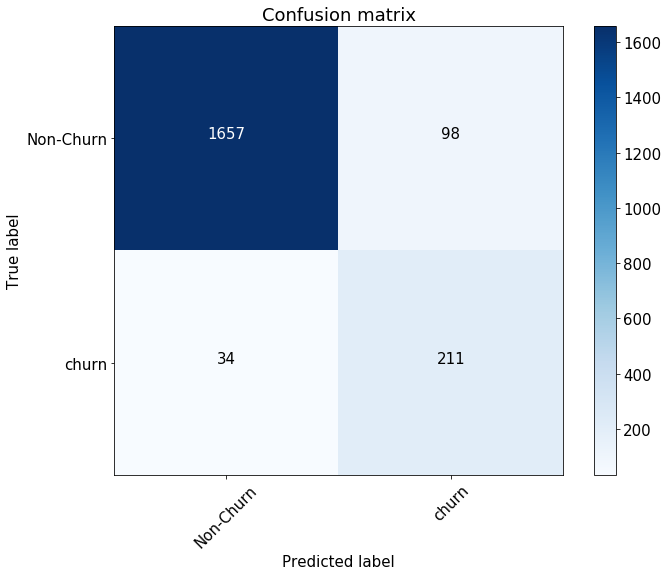

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [43]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

### Задача 3
Повторить п.2, но используя уже не медиану, а max

In [44]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, axis=0)
    return user_vector

In [45]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.126045,0.0,0.000000,0.211494,0.317864,0.030861,0.239208,0.486188,0.088734,...,0.135958,0.012462,0.000000,0.152798,0.031910,0.046852,0.079626,0.191123,0.119538,0.084095
1,u108690,0.200731,0.0,0.123496,0.214537,0.076103,0.072357,0.038529,0.463623,0.000000,...,0.031053,0.011181,0.010153,0.166768,0.015293,0.117817,0.045561,0.292713,0.054607,0.000000
2,u108339,0.050387,0.0,0.232664,0.184132,0.197341,0.074685,0.104647,0.148466,0.000000,...,0.088786,0.012416,0.000000,0.207303,0.000000,0.073264,0.089728,0.084322,0.189135,0.021050


In [46]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.126045,0.0,0.000000,0.211494,0.317864,0.030861,0.239208,0.486188,0.088734,...,0.012462,0.000000,0.152798,0.031910,0.046852,0.079626,0.191123,0.119538,0.084095,0
1,u108690,0.200731,0.0,0.123496,0.214537,0.076103,0.072357,0.038529,0.463623,0.000000,...,0.011181,0.010153,0.166768,0.015293,0.117817,0.045561,0.292713,0.054607,0.000000,1
2,u108339,0.050387,0.0,0.232664,0.184132,0.197341,0.074685,0.104647,0.148466,0.000000,...,0.012416,0.000000,0.207303,0.000000,0.073264,0.089728,0.084322,0.189135,0.021050,1


In [47]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [48]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0470612 , 0.00965129, 0.71118537, 0.17412897, 0.00958176,
       0.00926151, 0.046339  , 0.03115297, 0.0142607 , 0.18468095])

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.295557, F-Score=0.761, Precision=0.710, Recall=0.820


In [51]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9579696493982207

Confusion matrix, without normalization
[[1673   82]
 [  45  200]]


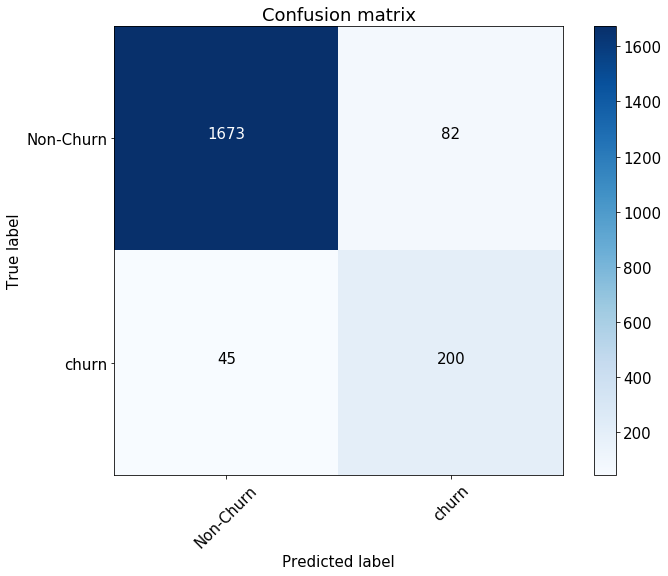

In [52]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [53]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

### Задача 4*
Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

### Задача 5
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [54]:
res = pd.DataFrame(results, columns=['Precision','Recall','Fscore','Roc_auc'])
res['Method']=['mean','median','max']
res

,Precision,Recall,Fscore,Roc_auc,Method
0,0.574713,0.816327,0.674536,0.943897,mean
1,0.683871,0.865306,0.763964,0.969094,median
2,0.710247,0.820408,0.761364,0.957970,max


Так как наш набор данных имеет сильный дисбаланс классов, то параметр Roc_auc можно не анализировать.
Лучшими себя показали методы median и max. В первом меньше точность, но лучше полнота, во втором наоборот. Fмера у них примерно одинакова.\
Эффективность метода median зависит от того, что он "выделяет" часто читаемые темы, редко читаемые, наоборот, обнуляет.
Метод max все темы считает приоритетными, нулевыми остаются только те, которые пользователь никогда не читал.